In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

class MarkovChain:
    def __init__(self, transition_matrix, states=None):
        """
        Initialize a Markov Chain with a transition matrix.

        Parameters:
        -----------
        transition_matrix : numpy.ndarray
            The transition probability matrix where P[i,j] is the
            probability of transitioning from state i to state j.
        states : list, optional
            Names of the states. If not provided, states will be numbered.
        """
        self.P = np.array(transition_matrix)
        n_states = self.P.shape[0]

        # Validate the transition matrix
        assert self.P.shape[0] == self.P.shape[1], "Transition matrix must be square"
        assert np.allclose(self.P.sum(axis=1), np.ones(n_states)), "Each row must sum to 1"

        # Set state names
        self.states = states if states is not None else [f"State {i}" for i in range(n_states)]

        # Create state index mapping
        self.state_indices = {state: i for i, state in enumerate(self.states)}

    def next_state(self, current_state):
        """
        Randomly sample the next state given the current state.

        Parameters:
        -----------
        current_state : str or int
            The current state (can be the state name or index)

        Returns:
        --------
        next_state : str
            The next state
        """
        if isinstance(current_state, str):
            current_idx = self.state_indices[current_state]
        else:
            current_idx = current_state

        next_idx = np.random.choice(len(self.states), p=self.P[current_idx])
        return self.states[next_idx]

    def generate_chain(self, length, start_state=None):
        """
        Generate a Markov Chain of specified length.

        Parameters:
        -----------
        length : int
            The length of the chain to generate
        start_state : str or int, optional
            The starting state. If None, a random state is chosen.

        Returns:
        --------
        chain : list
            A list of visited states
        """
        if start_state is None:
            current_state = np.random.choice(len(self.states))
        elif isinstance(start_state, str):
            current_state = self.state_indices[start_state]
        else:
            current_state = start_state

        chain = [self.states[current_state]]

        for _ in range(length - 1):
            next_state = self.next_state(current_state)
            chain.append(next_state)
            current_state = self.state_indices[next_state]

        return chain

    def compute_stationary_distribution(self):
        """
        Compute the stationary distribution of the Markov Chain.

        Returns:
        --------
        stationary : numpy.ndarray
            The stationary distribution
        """
        # Find eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eig(self.P.T)

        # Find which eigenvector corresponds to eigenvalue 1
        # (stationary distribution is the eigenvector with eigenvalue 1)
        idx = np.argmin(np.abs(eigenvalues - 1.0))
        stationary = np.real(eigenvectors[:, idx])

        # Normalize the eigenvector so it sums to 1
        stationary = stationary / np.sum(stationary)

        return stationary

    def compute_n_step_transition(self, n):
        """
        Compute the n-step transition matrix P^n.

        Parameters:
        -----------
        n : int
            Number of steps

        Returns:
        --------
        P_n : numpy.ndarray
            The n-step transition matrix
        """
        return np.linalg.matrix_power(self.P, n)

    def plot_transition_matrix(self, ax=None):
        """
        Plot the transition matrix as a heatmap.

        Parameters:
        -----------
        ax : matplotlib.axes.Axes, optional
            Axes to plot on. If None, a new figure is created.

        Returns:
        --------
        ax : matplotlib.axes.Axes
            The axes with the plot
        """
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 8))

        sns.heatmap(self.P, annot=True, cmap="Blues", fmt=".2f",
                   xticklabels=self.states, yticklabels=self.states, ax=ax)
        ax.set_title("Transition Matrix")
        ax.set_xlabel("To State")
        ax.set_ylabel("From State")

        return ax

    def plot_state_evolution(self, n_steps=20, start_state=None):
        """
        Plot the probability distribution evolution over n steps.

        Parameters:
        -----------
        n_steps : int, optional
            Number of steps to simulate
        start_state : str or int, optional
            The starting state. If None, uniform distribution over states.
        """
        if start_state is None:
            # Start with uniform distribution
            initial_dist = np.ones(len(self.states)) / len(self.states)
        else:
            # Start at a specific state
            initial_dist = np.zeros(len(self.states))
            if isinstance(start_state, str):
                initial_dist[self.state_indices[start_state]] = 1.0
            else:
                initial_dist[start_state] = 1.0

        # Calculate probability distribution for each step
        distributions = [initial_dist]
        current_dist = initial_dist

        for step in range(n_steps):
            current_dist = current_dist @ self.P
            distributions.append(current_dist)

        # Convert to numpy array for easier plotting
        distributions = np.array(distributions)

        # Plot the evolution
        fig, ax = plt.subplots(figsize=(12, 8))
        for i, state in enumerate(self.states):
            ax.plot(range(n_steps + 1), distributions[:, i],
                   marker='o', label=state)

        # Add stationary distribution as horizontal lines
        stationary = self.compute_stationary_distribution()
        for i, state in enumerate(self.states):
            ax.axhline(y=stationary[i], color=f'C{i}', linestyle='--', alpha=0.5)

        ax.set_xlabel("Step")
        ax.set_ylabel("Probability")
        ax.set_title("State Probability Evolution")
        ax.legend()
        ax.grid(True, alpha=0.3)

        return fig, ax

    def simulate_multiple_chains(self, n_chains=100, length=100, start_state=None):
        """
        Simulate multiple Markov chains and visualize the proportion of chains in each state.

        Parameters:
        -----------
        n_chains : int, optional
            Number of chains to simulate
        length : int, optional
            Length of each chain
        start_state : str or int, optional
            Starting state for all chains

        Returns:
        --------
        fig : matplotlib.figure.Figure
            The figure with the plot
        """
        # Initialize all chains
        chains = []
        for _ in range(n_chains):
            chain = self.generate_chain(length, start_state)
            chains.append(chain)

        # Convert to numpy array for easier indexing
        chains = np.array(chains)

        # Count states at each time step
        state_counts = np.zeros((length, len(self.states)))

        for t in range(length):
            for s_idx, state in enumerate(self.states):
                state_counts[t, s_idx] = np.sum(chains[:, t] == state)

        # Convert to proportions
        state_proportions = state_counts / n_chains

        # Plot
        fig, ax = plt.subplots(figsize=(12, 8))

        for s_idx, state in enumerate(self.states):
            ax.plot(range(length), state_proportions[:, s_idx],
                   marker='.', label=state)

        # Add stationary distribution as horizontal lines
        stationary = self.compute_stationary_distribution()
        for i, state in enumerate(self.states):
            ax.axhline(y=stationary[i], color=f'C{i}', linestyle='--', alpha=0.5)

        ax.set_xlabel("Step")
        ax.set_ylabel("Proportion of Chains")
        ax.set_title(f"Proportion of {n_chains} Chains in Each State Over Time")
        ax.legend()
        ax.grid(True, alpha=0.3)

        return fig, ax

    def visualize_chain_path(self, length=20, start_state=None):
        """
        Visualize a single Markov chain path.

        Parameters:
        -----------
        length : int, optional
            Length of the chain
        start_state : str or int, optional
            Starting state for the chain

        Returns:
        --------
        fig : matplotlib.figure.Figure
            The figure with the plot
        """
        # Generate a single chain
        chain = self.generate_chain(length, start_state)

        # Convert states to indices for plotting
        chain_indices = [self.state_indices[state] for state in chain]

        # Create a colormap with one color per state
        colors = plt.cm.tab10(np.linspace(0, 1, len(self.states)))
        cmap = ListedColormap(colors)

        # Plot
        fig, ax = plt.subplots(figsize=(12, 4))

        # Plot the state sequence as colored blocks
        for t in range(length):
            state_idx = chain_indices[t]
            rect = plt.Rectangle((t, 0), 1, 1, color=colors[state_idx])
            ax.add_patch(rect)

            # Add state label in the middle of each block
            ax.text(t + 0.5, 0.5, chain[t],
                   ha='center', va='center', fontsize=10)

        # Set plot limits and labels
        ax.set_xlim(0, length)
        ax.set_ylim(0, 1)
        ax.set_xticks(np.arange(length) + 0.5)
        ax.set_xticklabels(range(length))
        ax.set_yticks([])

        ax.set_xlabel("Step")
        ax.set_title("Single Markov Chain Path")

        # Add a legend
        handles = [plt.Rectangle((0, 0), 1, 1, color=colors[i])
                  for i in range(len(self.states))]
        ax.legend(handles, self.states, loc='upper center',
                 bbox_to_anchor=(0.5, -0.15), ncol=len(self.states))

        return fig, ax



In [3]:
# Example 1: Weather Model
# Sunny → Sunny (0.8), Cloudy (0.15), Rainy (0.05)
# Cloudy → Sunny (0.3), Cloudy (0.4), Rainy (0.3)
# Rainy → Sunny (0.2), Cloudy (0.35), Rainy (0.45)

# Define the transition matrix
weather_transition = np.array([
    [0.8, 0.15, 0.05],   # From Sunny
    [0.3, 0.4, 0.3],     # From Cloudy
    [0.2, 0.35, 0.45]    # From Rainy
])

# Define the state names
weather_states = ["Sunny", "Cloudy", "Rainy"]

# Create the Markov Chain
weather_mc = MarkovChain(weather_transition, weather_states)



In [4]:
# Example 2: Student Study Habits
# S1: Focused → Focused (0.7), Distracted (0.2), Break (0.1)
# S2: Distracted → Focused (0.4), Distracted (0.5), Break (0.1)
# S3: Break → Focused (0.6), Distracted (0.3), Break (0.1)

study_transition = np.array([
    [0.7, 0.2, 0.1],   # From Focused
    [0.4, 0.5, 0.1],   # From Distracted
    [0.6, 0.3, 0.1]    # From Break
])

study_states = ["Focused", "Distracted", "Break"]
study_mc = MarkovChain(study_transition, study_states)



### Demonstration of key properties for the weather example

<Figure size 1000x800 with 0 Axes>

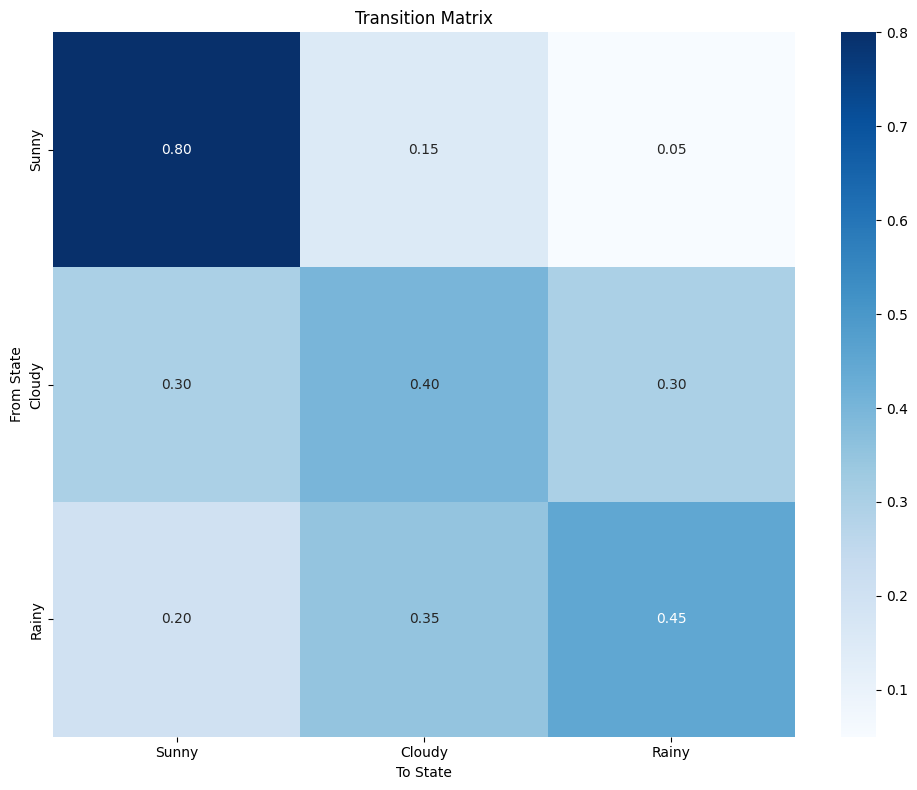

In [5]:
# 1. Visualize the transition matrix
plt.figure(figsize=(10, 8))
weather_mc.plot_transition_matrix()
plt.tight_layout()
plt.show()



In [6]:
# 2. Generate and print a sample chain
np.random.seed(42)  # For reproducibility
weather_chain = weather_mc.generate_chain(length=10, start_state="Sunny")
print("Sample Markov Chain (Weather):", weather_chain)



Sample Markov Chain (Weather): ['Sunny', 'Sunny', 'Rainy', 'Rainy', 'Rainy', 'Sunny', 'Sunny', 'Sunny', 'Cloudy', 'Cloudy']


In [7]:
# 3. Compute and print the stationary distribution
stationary = weather_mc.compute_stationary_distribution()
print("\nStationary Distribution:")
for state, prob in zip(weather_states, stationary):
    print(f"{state}: {prob:.4f}")




Stationary Distribution:
Sunny: 0.5625
Cloudy: 0.2500
Rainy: 0.1875


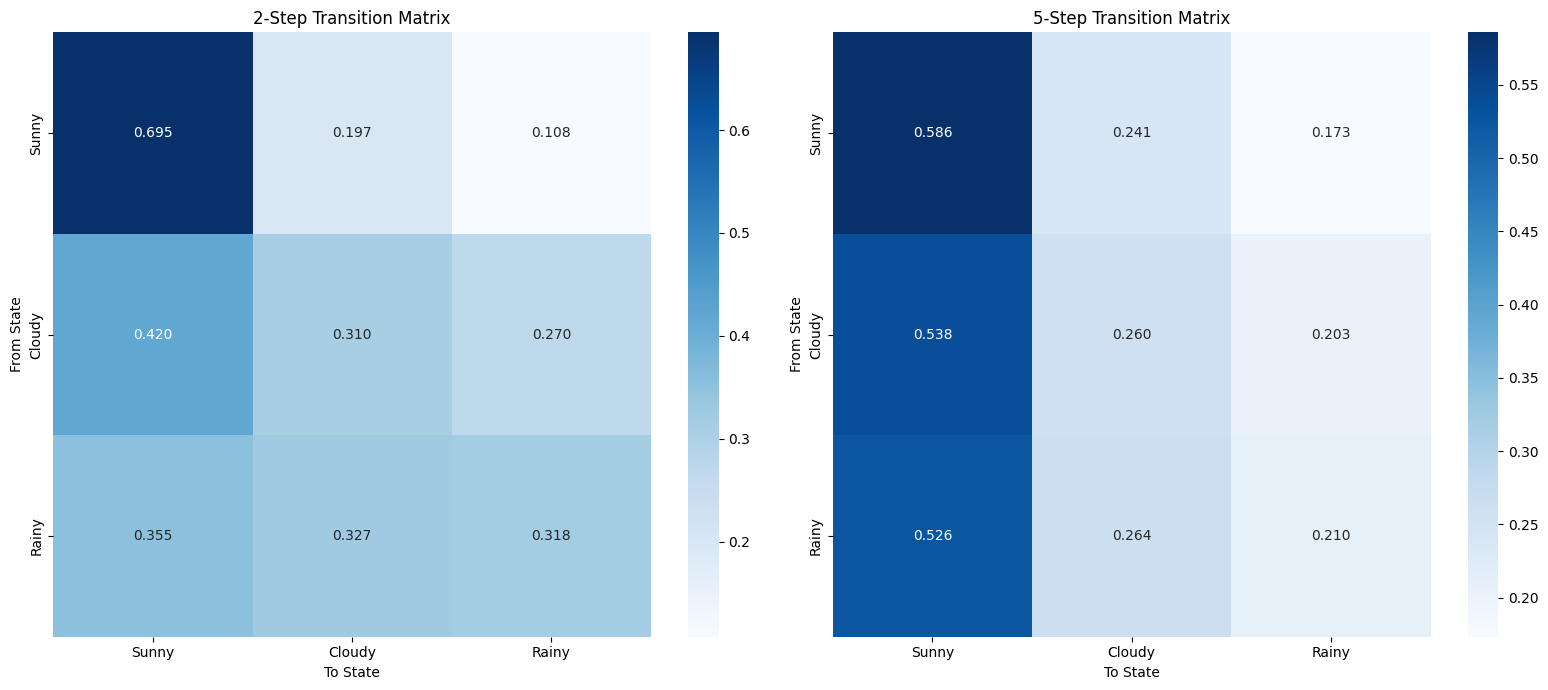

In [8]:
# 4. Compute and visualize 2-step and 5-step transition matrices
two_step = weather_mc.compute_n_step_transition(2)
five_step = weather_mc.compute_n_step_transition(5)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))
sns.heatmap(two_step, annot=True, cmap="Blues", fmt=".3f",
            xticklabels=weather_states, yticklabels=weather_states, ax=axes[0])
axes[0].set_title("2-Step Transition Matrix")
axes[0].set_xlabel("To State")
axes[0].set_ylabel("From State")

sns.heatmap(five_step, annot=True, cmap="Blues", fmt=".3f",
            xticklabels=weather_states, yticklabels=weather_states, ax=axes[1])
axes[1].set_title("5-Step Transition Matrix")
axes[1].set_xlabel("To State")
axes[1].set_ylabel("From State")

plt.tight_layout()
plt.show()



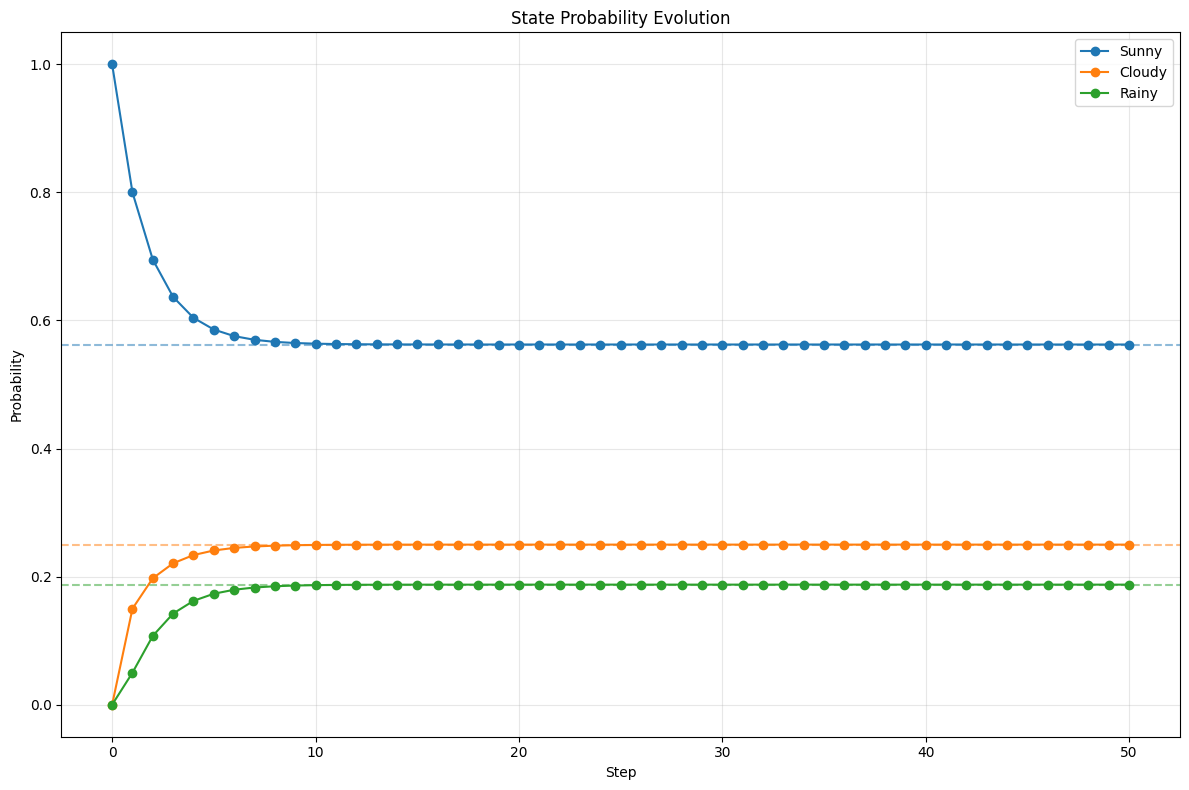

In [9]:
# 5. Visualize state probability evolution
fig, ax = weather_mc.plot_state_evolution(n_steps=50, start_state="Sunny")
plt.tight_layout()
plt.show()



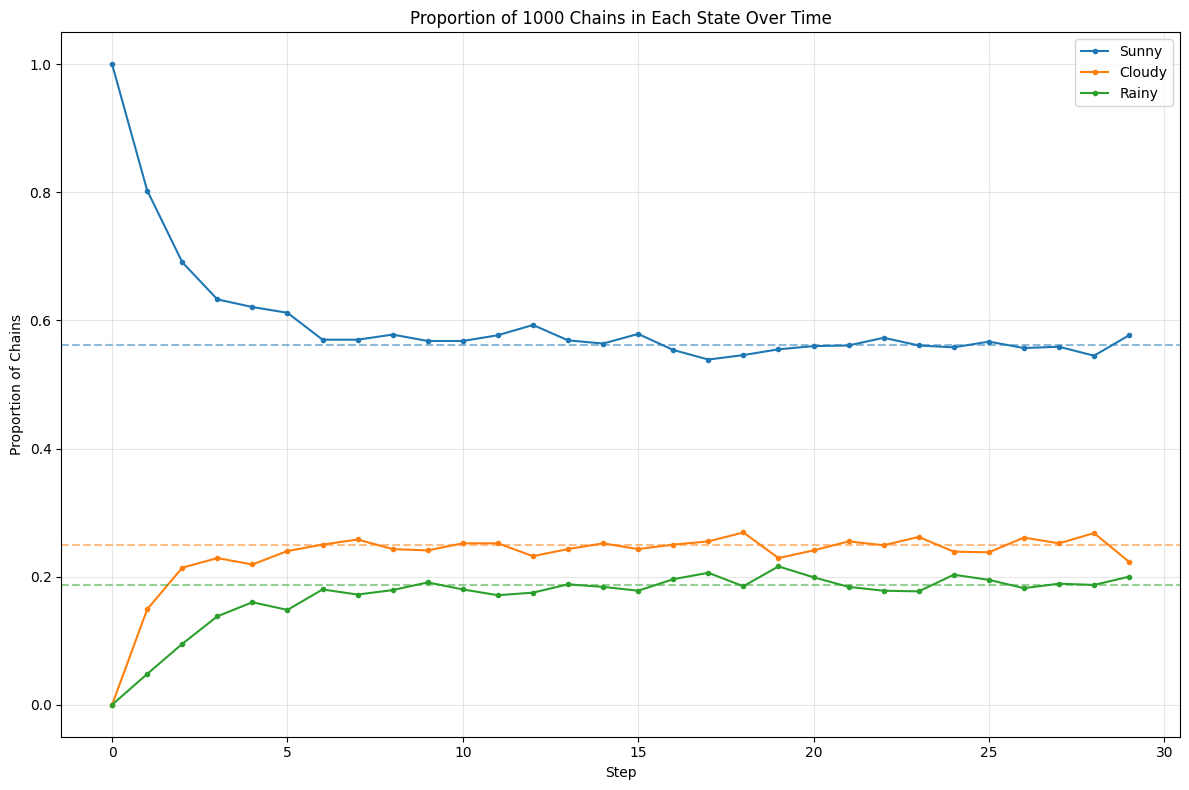

In [10]:
# 6. Simulate and visualize multiple chains
fig, ax = weather_mc.simulate_multiple_chains(n_chains=1000, length=30, start_state="Sunny")
plt.tight_layout()
plt.show()


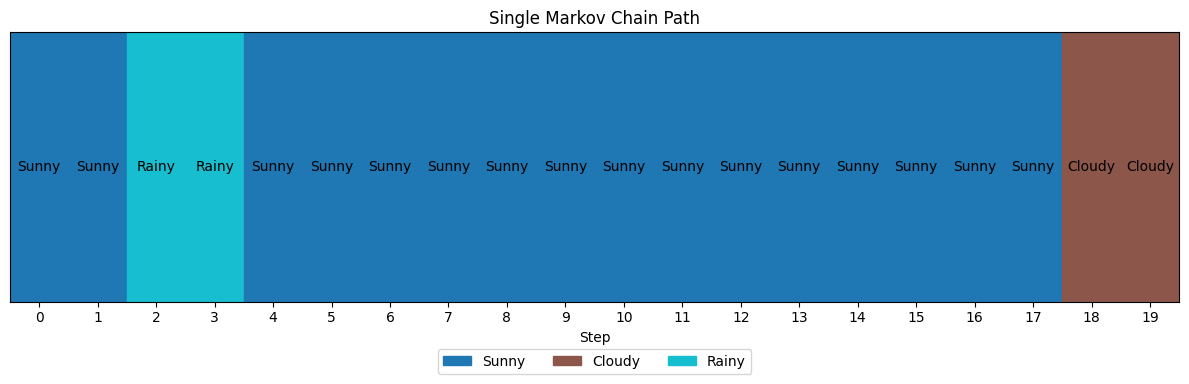

In [11]:

# 7. Visualize a single chain path
fig, ax = weather_mc.visualize_chain_path(length=20, start_state="Sunny")
plt.tight_layout()
plt.show()